In [1]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.docstore.document import Document


# 1. Load Document

In [2]:
original_filename = "docs/Propuesta-Nueva-Constitucion.pdf"
text_filename = "docs/Propuesta-Nueva-Constitucion.txt"
capitulos_filaname = "docs/capitulos/Propuesta-Nueva-Constitucion"

# Carga el pdf completo
loader = PyPDFLoader(original_filename)
pages = loader.load()


In [3]:
# Junta todo el texto:
all_text = ''.join([page.page_content for page in pages])
print("chars:",len(all_text))
print("words:",len(all_text.split(" ")))



chars: 334771
words: 52072


In [60]:
import re  

pattern = r"propuesta constitución política de la república de chile\d+"
all_text_clean1 = re.sub(pattern, "", all_text.lower()) 
print("chars:",len(all_text_clean1))
print("words:",len(all_text_clean1.split(" ")))
with open(text_filename, "w") as txt_file:
    txt_file.write(all_text_clean1)

chars: 329631
words: 51456


In [62]:
# divide por capitulos:
import re
pattern = "capítulo \w+\n"
capitulos = re.split(pattern, all_text_clean1.lower())
print("Capitulos:", len(capitulos))

Capitulos: 18


In [67]:
#Guarda los capitulos       
for i, capitulo in enumerate(capitulos):
    _name = f"{capitulos_filaname}.{i}.txt"
    with open(_name, "w") as cap_text_file:
        cap_text_file.write(capitulo)    

# ultimo capitulo tiene disposiciones transitorias
ultimo_capitulo =  capitulos[-1].split("disposiciones transitorias\n")
with open( f"{capitulos_filaname}.17.txt", "w") as cap_text_file:
    cap_text_file.write(ultimo_capitulo[0])
with open( f"{capitulos_filaname}.disposiciones_transitorias.txt", "w") as cap_text_file:
    cap_text_file.write(ultimo_capitulo[1].split(""))    
    # Despues de esto manualmente remueve el indice

In [4]:
# Procesamos los capitulos

lista_capitulos_index = [i for i in range(18)]
lista_capitulos_index.append("disposiciones_transitorias")

capitulos_finales = []

for cap_index in lista_capitulos_index:
    _name = f"{capitulos_filaname}.{cap_index}.txt"
    with open(_name) as cap_text_file:
        file_content = cap_text_file.read()
        capitulos_finales.append({
            "metadata" : {"capitulo": cap_index},
            "content": file_content
        })


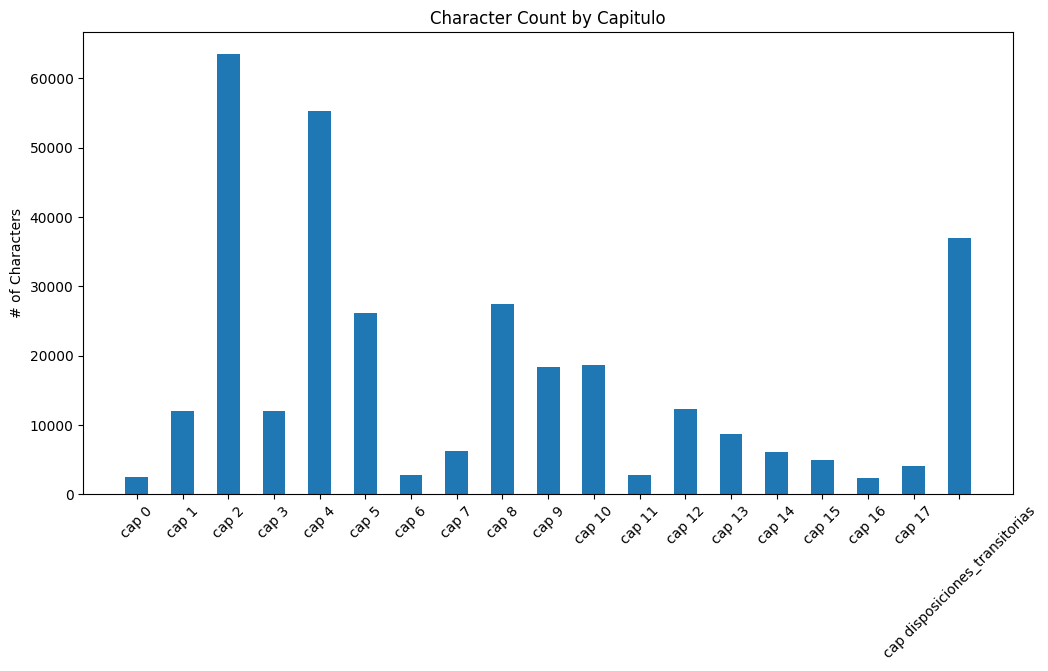

In [5]:


import matplotlib.pyplot as plt  

texts = capitulos_finales  

char_counts = [len(text["content"]) for text in texts]  
labels  = [f'cap {text["metadata"]["capitulo"]}'for  text in texts]  
plt.figure(figsize=(12, 6))   

plt.bar(labels, char_counts, width=0.5)  
plt.ylabel('# of Characters')  
plt.title('Character Count by Capitulo')  
plt.xticks(rotation=45)
plt.show()

In [6]:
articulos_finales = []

In [7]:
# Ahora a separar por articulos:

def process_capitulo(capitulo_number):
    #print(capitulo_number)
    art_pattern = "\nartículo "
    articulos = capitulos_finales[capitulo_number]['content'].split(art_pattern)
    nombre_capitulo = articulos[0]

    for art in articulos[1:]:
        if "," not in art[:4]:
            parts = art.split("\n")
            art_number = int(parts[0].split(" ")[0].replace(".",""))
            articulos_finales.append({
                    "metadata" : {"capitulo": capitulo_number,  "nombre_capitulo": nombre_capitulo, "articulo": art_number},
                    "content": art
                })

In [8]:
for cn in range(1,18):
    process_capitulo(cn)

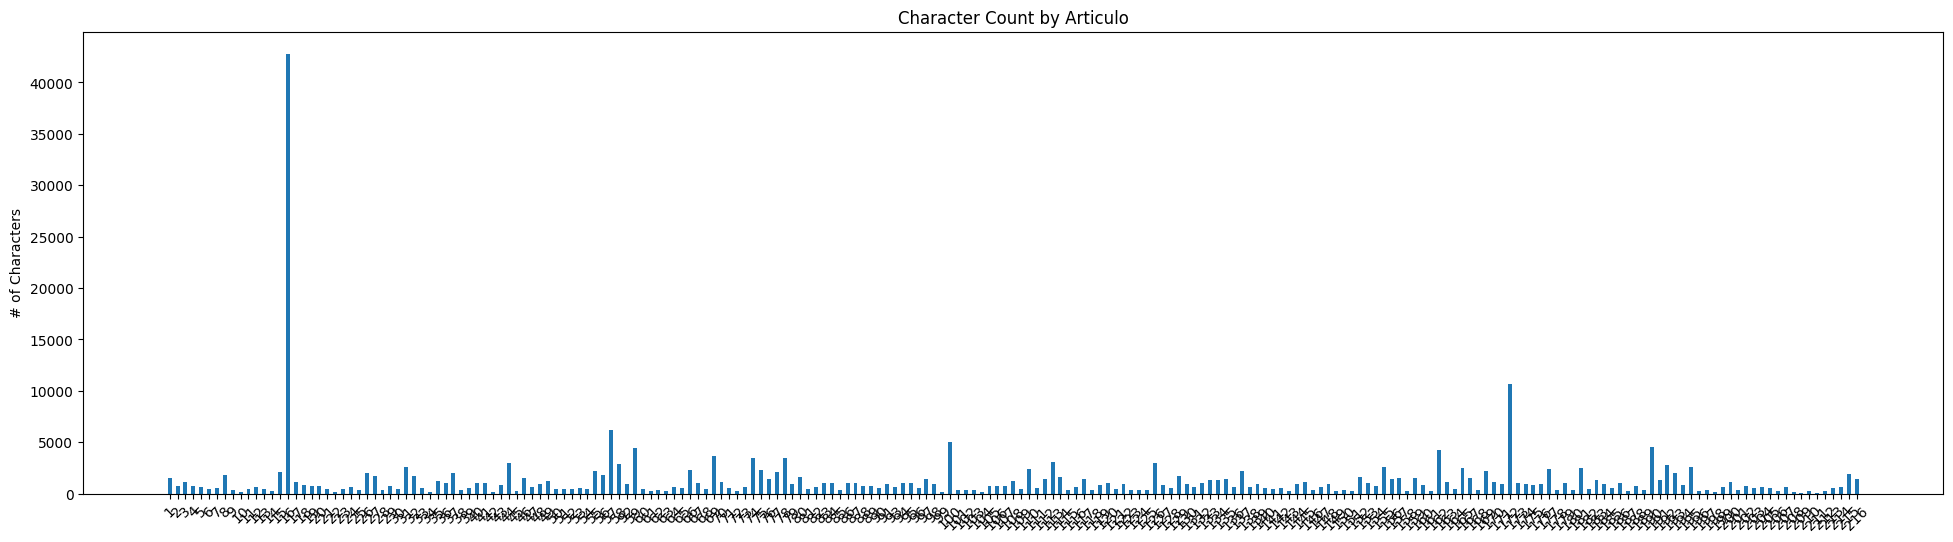

In [9]:

texts = articulos_finales  

char_counts = [len(text["content"]) for text in texts]  
labels  = [f'{text["metadata"]["articulo"]}'for  text in texts]  
plt.figure(figsize=(24, 6))   

plt.bar(labels, char_counts, width=0.5)  
plt.ylabel('# of Characters')  
plt.title('Character Count by Articulo')  
plt.xticks(rotation=45)
plt.show()

In [10]:
#for af in articulos_finales:
    #print (f'{af["metadata"]["capitulo"]}:{af["metadata"]["nombre_capitulo"]}:{af["metadata"]["articulo"]}:({len(af["content"])}): {af["content"][:50]}\n')

In [11]:
len(articulos_finales[15]['content'])

42802

In [12]:
art_docs = []
for i,af in enumerate(articulos_finales):
    art_docs.append(Document(page_content=articulos_finales[i]['content'], metadata= articulos_finales[i]['metadata']))

In [13]:
len(art_docs)

217

In [14]:
#txt_doc = "docs/Constitucion_Chilena_1980_s_notas.txt"
#with open (txt_doc) as f:
#    contents = f.read()

In [15]:
art_docs[216]

Document(page_content='216\n1. la convocatoria a plebiscito deberá efectuarse dentro de los treinta días \nsiguientes a aquel en que ambas cámaras insistan en el proyecto aprobado por \nellas y se ordenará mediante decreto supremo que fijará la fecha de la votación, la \nque se celebrará ciento veinte días después de la publicación de dicho decreto si \nese día correspondiere a un domingo. si así no fuere, ella se realizará el domingo \ninmediatamente siguiente. transcurrido este plazo sin que el presidente de la \nrepública convoque a plebiscito, se promulgará el proyecto que hubiere aprobado \nel congreso nacional.\n2. el decreto de convocatoria contendrá, según corresponda, el proyecto aprobado \npor ambas cámaras y vetado totalmente por el presidente de la república, o las \ncuestiones del proyecto en las cuales el congreso haya insistido, según lo dispuesto \nen los incisos 4 y 5 del artículo anterior. en este último caso, cada una de las \ncuestiones en desacuerdo deberá ser vota

# 2. Split Document (3000, 300)

In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", "\. ", " ", ""],
    chunk_size=4000,
    chunk_overlap=1000,
    length_function=len
)

In [17]:
docs = text_splitter.split_documents(art_docs)

In [18]:

for d in docs:
    d.page_content = f"Capitulo {d.metadata['capitulo']}: {d.metadata['nombre_capitulo']}\narticulo {d.metadata['articulo']}\n{d.page_content}"

In [42]:
len(docs[18].page_content.split(" "))


627

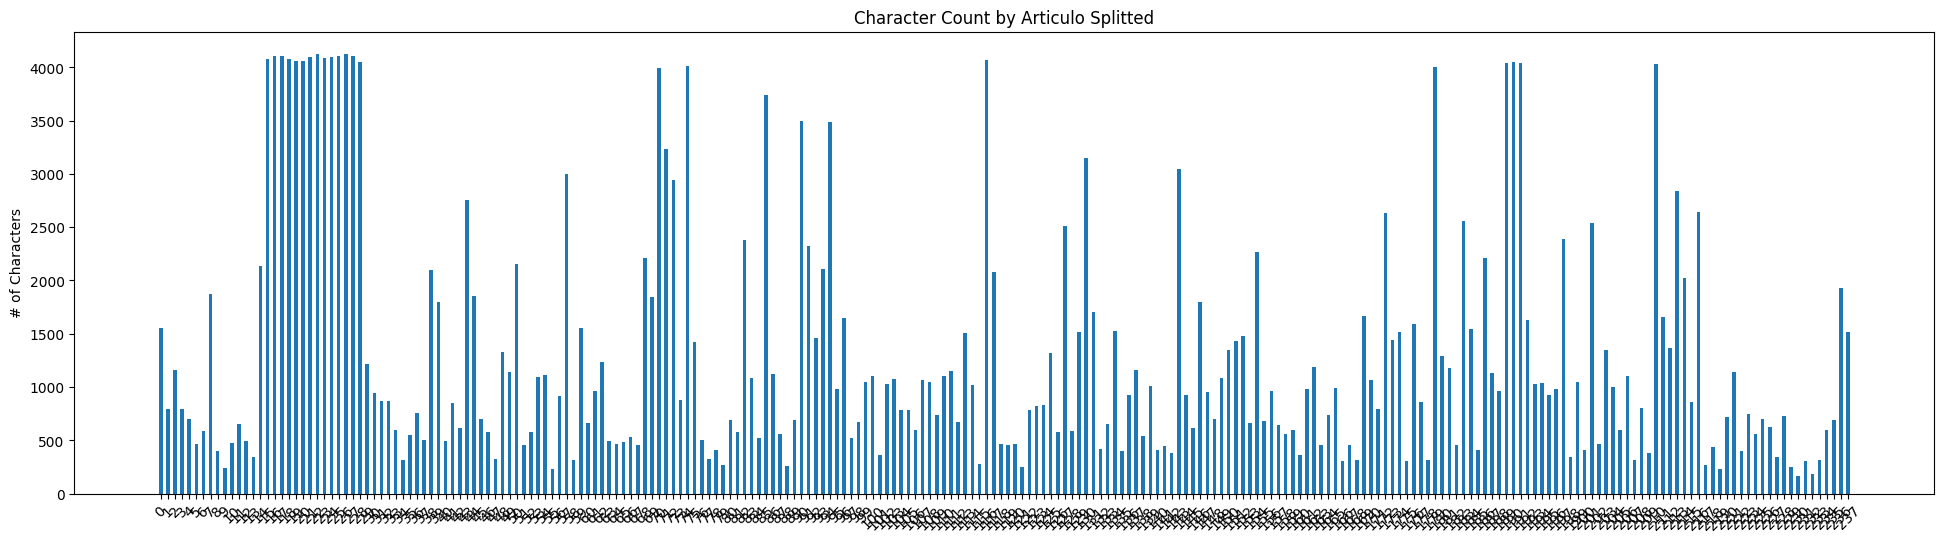

In [20]:
texts = docs  

char_counts = [len(doc.page_content) for doc in texts]  
labels  = [str(i) for  i,doc in enumerate(texts)]  
plt.figure(figsize=(24, 6))   

plt.bar(labels, char_counts, width=0.5)  
plt.ylabel('# of Characters')  
plt.title('Character Count by Articulo Splitted')  
plt.xticks(rotation=45)
plt.show()

In [21]:
docs[15].metadata, docs[16].metadata, 

({'capitulo': 2,
  'nombre_capitulo': 'derechos y libertades fundamentales, garantías y deberes \nconstitucionales\nderechos y libertades fundamentales',
  'articulo': 16},
 {'capitulo': 2,
  'nombre_capitulo': 'derechos y libertades fundamentales, garantías y deberes \nconstitucionales\nderechos y libertades fundamentales',
  'articulo': 16})

# 3. Create Embeddings

In [45]:
from langchain.embeddings import BedrockEmbeddings 
#from langchain.embeddings import OpenAIEmbeddings

bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1")
#embeddings = OpenAIEmbeddings()

In [46]:
bedrock_embeddings.embed_query(text="Hola Mundo")[:3]#, OpenAIEmbeddings.embed_query(text="Hola Mundo")

[0.51953125, 0.44921875, 0.32421875]

In [30]:
from langchain.vectorstores import Chroma

In [31]:
persist_directory = "./streamlit/docs/chroma/"
!rm -rf ./streamlit/docs/chroma  # remove old database files if any

In [32]:
vectordb2 = Chroma.from_documents(
    documents=docs,
    embedding=bedrock_embeddings,
    persist_directory=persist_directory
)
print(vectordb2._collection.count())

238


In [33]:
question = "Como se compone el Congreso Nacional?"
responses = vectordb2.similarity_search(question,k=8)

In [34]:
responses[0].metadata

{'articulo': 60, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}

In [35]:
for resp in responses:
    print (resp.metadata)
    #print(resp.page_content[:1000])


{'articulo': 60, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 63, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 61, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 51, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 83, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 59, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 73, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 57, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}


In [36]:
vectordb2.persist()

In [37]:
print(vectordb2._collection.count())

238


In [38]:
docs_mmr = vectordb2.max_marginal_relevance_search(question,k=8)

In [39]:
for resp in docs_mmr:
    print (resp.metadata)

{'articulo': 60, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 63, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 61, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 59, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 73, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 80, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 84, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
{'articulo': 64, 'capitulo': 4, 'nombre_capitulo': 'congreso nacional'}
